# EBA3500 Lecture 4: Classification, proper scoring rules, and likelihood

## Binary classification (binary regression)
We'll work with an example from [this page](https://stats.idre.ucla.edu/r/dae/logit-regression/) about admission to colleges. 

> This dataset has a binary response (outcome, dependent) variable called **admit**. There are three predictor variables: **gre**, **gpa** and **rank**. We will treat the variables gre and gpa as continuous. The variable rank takes on the values 1 through 4. Institutions with a rank of 1 have the highest prestige, while those with a rank of 4 have the lowest. 

Here `gre` is the [Graduate Record Examinations](https://en.wikipedia.org/wiki/Graduate_Record_Examinations), a test used when applying to grad school, and `gpa` is the grade point average. Let's have a look at the structure of the data!


In [ ]:
import pandas as pd
admission = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")
admission[1:6]

,admit,gre,gpa,rank
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2


Now we have a rough understanding of the structure of the data, so let's take a look at some plots.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(admission)
plt.show()

NameError: ignored

The `sns.pairplot` function is handy, as it allows us a quick and easy look at the data. We will have many more occasions to use function such as this. Remember, as a data analyst you must be sure to look at the data. If you don't, you'll never understand it.


In [ ]:
import numpy as np
np.corrcoef(np.asarray(admission.T)) 

array([[ 1.        ,  0.18443428,  0.17821225, -0.24251318],
       [ 0.18443428,  1.        ,  0.38426588, -0.12344707],
       [ 0.17821225,  0.38426588,  1.        , -0.05746077],
       [-0.24251318, -0.12344707, -0.05746077,  1.        ]])

No very impressive correlations to find, but we may not want to calculate correlations involving categorical variables such as `admit` and `rank` at all! Anyhow, for the rest of this lecture we will have a look at `gre`. 

### Goal 
> Estimate the probability of acceptance (`admit`) given the GRE variable (`gre`)!

Using `sns.lmplot` we may make a scatterplot with a regression line (least squares) without going through all that `smf` hassle.

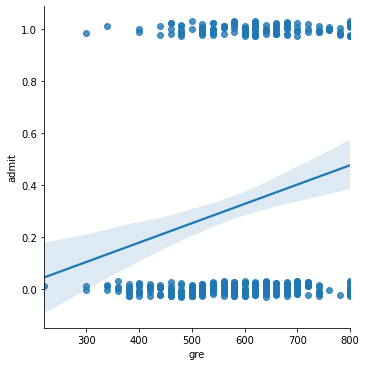

In [ ]:
sns.lmplot(x="gre", y="admit", data=admission, y_jitter = .03)
# admission["gre"].values

That plot shows the effect of `gre` on the probability of acceptance to a college. But does the `rank` affect it as well?

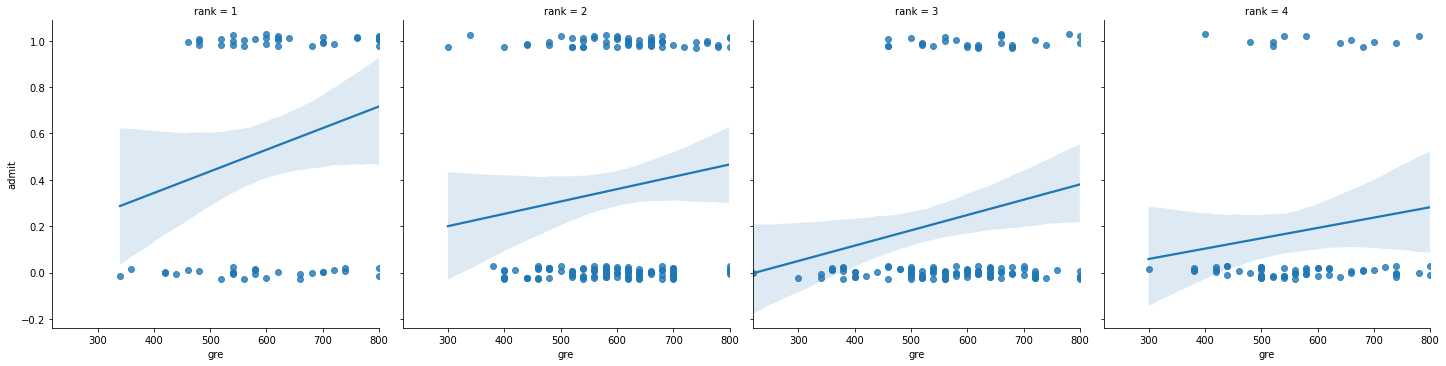

In [ ]:
sns.lmplot(x="gre", y="admit", col = "rank", data=admission, y_jitter = .03)
plt.show()

The third plot indicates what may happen when we fit a linear regression line to `0-1` data. The line may predict an impossible probability! The following example should make it clear:

In [ ]:
import numpy as np
x = np.linspace(0, 1, 11)
y = np.array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1])
sns.lmplot(x="x", y="y", data=pd.DataFrame({'x':x, 'y':y}))
plt.show()

NameError: ignored

The example above fits a line that is greater thant $1$ when $x \approx 1$. But probabilities are always between $0$ and $1$. 

How can we fix this? [Just Google it!](https://www.google.com/search?q=function+between+0+and+1&oq=function+between&aqs=chrome.2.69i57j0i512j0i22i30l8.6456j0j7&sourceid=chrome&ie=UTF-8) The class of [sigmoid functions](https://en.wikipedia.org/wiki/Sigmoid_function) appears to be, roughly, what we need. The first function, the [logistic function](https://en.wikipedia.org/wiki/Sigmoid_function#Examples), $f(x) = \frac{1}{1+e^{-x}}$, seems particularily simple to work with. 





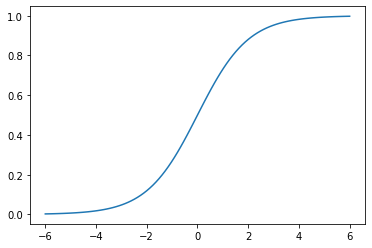

In [ ]:
logistic = lambda x: 1/(1 + np.exp(-x))
x_ = np.linspace(-6, 6, 100)
plt.plot(x_, logistic(x_))
plt.show()

Recall the function `curve_fit` from the last lecture, we used that one to fit arbitrary functions to the data, using least squares. We may use that one here, too! That is, we want to minimize
$$\sum_{i=1}^{n}(y_{i}-F(a + bx_i))^{2} = \sum_{i=1}^{n}\left(y_{i}-\frac{1}{1+e^{-{(a + bx_i)}}}\right)^{2}.$$

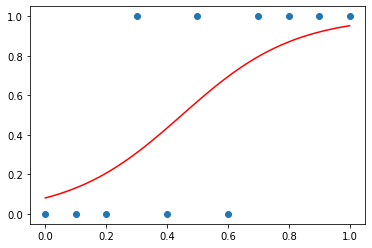

In [ ]:
from scipy.optimize import curve_fit
func_logistic = lambda x, a, b: logistic(a + b * x)
param_logistic = curve_fit(func_logistic, x, y)[0]

plt.scatter(x, y)
x_ = np.linspace(0, 1, 100)
plt.plot(x_, func_logistic(x_, param_logistic[0], param_logistic[1]), color = "red")
plt.show()

This works well, but how about other functions? We just choose a semi-random function from the list of sigmoids. In fact, that is the most commonly used function in classification, and gives rise to the name **logistic regression**, sometimes also called **logit regression**. However, there are infinitely many functions to choose from. We will go through some of them in the exercises. 

But what we typically want are functions $F(x)$ that are _increasing_ from $0$ to $1$. We want $F$ to be increasing for at least two reasons:

1.   **For interpretation.** Increasing functions are OK to interpret, complex functions going up and down are usually not.
2.   **For computation's sake.** Complex functions are really hard to optimize.
3.   **For tradition.** It has been done this way since the 20s. It's hard to beat tradition.
Considering interpretation, just take a look at the following function, which
isn't increasing at all!



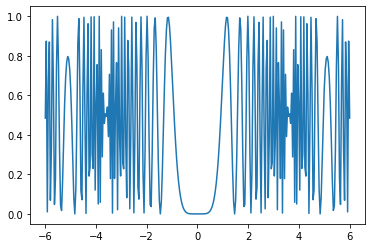

In [ ]:
insidious = lambda x: np.sin(x ** 3)**2
x_ = np.linspace(-6, 6, 300)
plt.plot(x_, insidious(x_))
plt.show()



It happens that the class of increasing functions from $0$ to $1$ are known as [cumulative distribution functions](https://en.wikipedia.org/wiki/Cumulative_distribution_function). You can find many examples of such functions in the [`scipy`](https://docs.scipy.org/doc/scipy/reference/stats.html) package. In the context of binary regression, these functions are called **link functions**. The most important function (beside the logistic function) that is commonly used is the normal cumulative distribution function, sometimes calles the probit function, giving rise to **probit regression**.



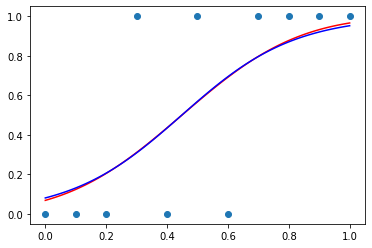

In [ ]:
from scipy import stats

func_logistic = lambda x, a, b: logistic(a + b * x)
param_logistic = curve_fit(func_logistic, x, y)[0]

func_norm = lambda x, a, b: stats.norm.cdf(a + b * x)
param_norm = curve_fit(func_norm, x, y)[0]

plt.scatter(x, y)
x_ = np.linspace(0, 1, 100)
plt.plot(x_, func_norm(x_, param_norm[0], param_norm[1]), color = "red")
plt.plot(x_, func_logistic(x_, param_logistic[0], param_logistic[1]), color = "blue")
plt.show()

In [ ]:
print(param_norm, param_logistic)

[-1.48679464  3.31086396] [-2.43131386  5.41986729]


These curves almost indistinguishable - which is usually the case. However, their parameters are not the same, and shouldn't be interpreted as an intercept and a slope. (There is a nice interpretation of the parameters though, those interested may read about the latent variable interpretation of binary regression models on e.g [wikipedia](https://en.wikipedia.org/wiki/Binary_regression#Latent_variable_model)).



Now let's go back to the `admit` vs `gre` problem!


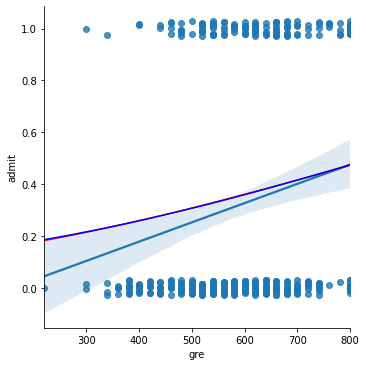

In [ ]:
x = admission["gre"].values
y = admission["admit"].values
x_center = (x - np.mean(x)) / np.std(x) # centering and standardizing!

param_logit = curve_fit(func_logistic, x_center, y)[0]
param_norm = curve_fit(func_norm, x_center, y)[0]

sns.lmplot(x="gre", y="admit", data=admission, y_jitter = .03)
x_ = np.linspace(min(x), max(x), 100)
x_center_ = (x_ - np.mean(x_)) / np.std(x_)
plt.plot(x_, func_norm(x_center_, param_norm[0], param_norm[1]), color = "red")
plt.plot(x_, func_logistic(x_center_, param_logit[0], param_logit[1]), color = "blue")
plt.show()

I did the transformations on `x` to make the algorithm run. Such manipulations are often necessary to do.

## But this is not what's usually done!
Classification is super important and used everywhere, both in science and in business. But no one uses `curve_fit` or similar functions for this purpose. Why not?! Most people do not minimize the square in classification, i.e., they do not mizimize 
$$\sum_{i=1}^{n}(y_{i}-p_{i})^{2},$$
where $p_i = F(x_i, a_1, a_2, \ldots, a_p)$ is a function, such as the function `func` you plug into the the `curve_fit` function.

Instead, they minimize the *log score*:
$$\sum_{i=1}^{n}-y_{i}\log p_{i}-(1-y_{i})\log(1-p_{i}).$$

Why would anyone in their right mind do this? It appears deranged, but it's 
actually quite smart.

We prefer the log score because it is
1.   The *_log-likelihood_* of the *_Bernoulli distribution_*
    * Which implies the estimator is *_efficient_*.
    * I.e., as good as it can be, in a certain sense.
2.   A *_proper scoring rule_* with better motivation than the *_quadratic scoring rule_*.
3.   **Tradition.** Do not underestimate the power of tradition.

You will learn about these concepts soon enough. But first, let's fit probit
and logistic regressions in Python.

`seaborn` can plot the result of a logistic regression by adding `logistic = True`. At least some of its functions can.






/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


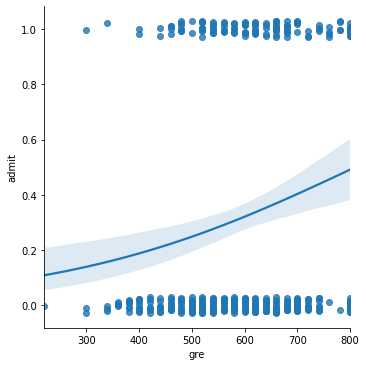

In [ ]:
sns.lmplot(x="gre", y="admit", data=admission, y_jitter = .03, logistic = True)

We can also make grids with `logistic = True`. (You may wish to use `ci = None` to avoid computation of the confidence bands in light blue.)

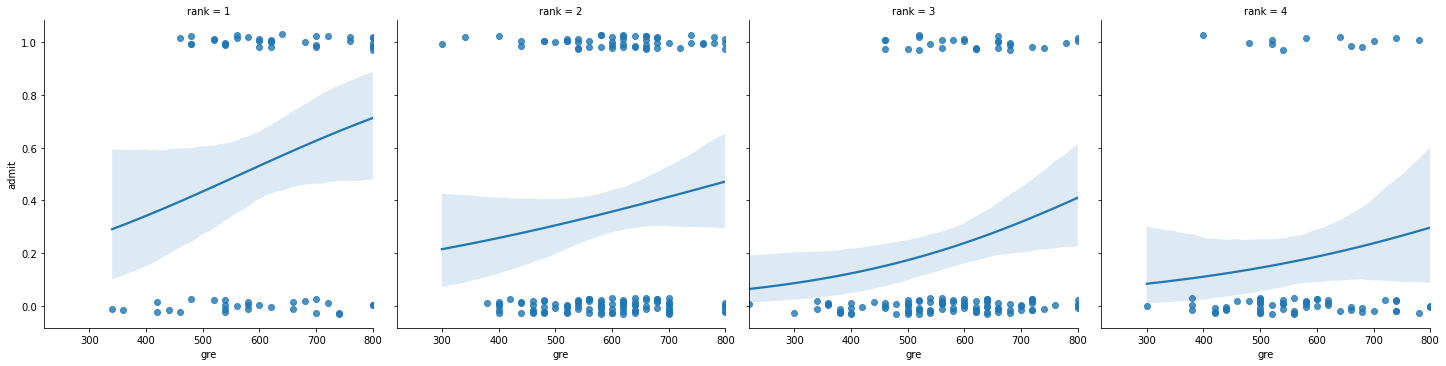

In [ ]:
sns.lmplot(x="gre", y="admit", col = "rank", data=admission, y_jitter = .03, logistic = True)
plt.show()

You may wish to use ci = None to avoid computation of the confidence bands in light blue.


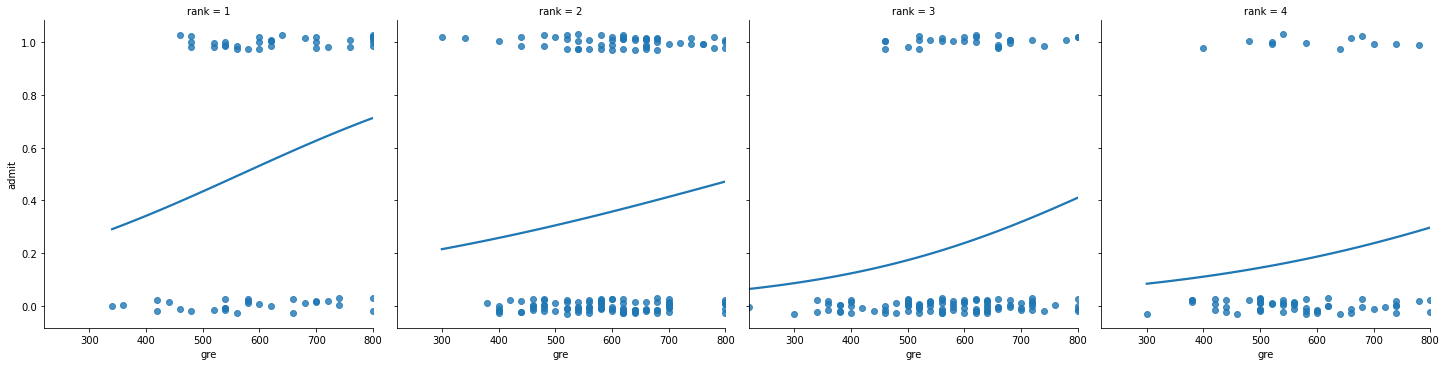

In [ ]:
sns.lmplot(x="gre", y="admit", col = "rank", data=admission, y_jitter = .03, logistic = True, ci = None)
plt.show()

We will use the `smf.glm` function to fit the models. But there are many ways to fit logistic and probit regressions in Python. We see a alot of output! In particular, notice the *p*-values and the confidence intervals for the parameters.

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
mod_logistic = smf.glm(formula="admit ~ gre", data=admission, family=sm.families.Binomial()).fit()
print(mod_logistic.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  admit   No. Observations:                  400
Model:                            GLM   Df Residuals:                      398
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -243.03
Date:                Wed, 15 Sep 2021   Deviance:                       486.06
Time:                        09:30:31   Pearson chi2:                     399.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9013      0.606     -4.787      0.0

In [ ]:
mod_probit = smf.glm(formula="admit ~ gre", data=admission, family=sm.families.Binomial(sm.genmod.families.links.probit())).fit()
print(mod_probit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  admit   No. Observations:                  400
Model:                            GLM   Df Residuals:                      398
Model Family:                Binomial   Df Model:                            1
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -242.99
Date:                Wed, 15 Sep 2021   Deviance:                       485.99
Time:                        09:50:27   Pearson chi2:                     399.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7682      0.358     -4.940      0.0

You can also use `smf.probit` and `smf.logit` directly.

In [ ]:
print(smf.logit("admit ~ gre", data = admission).fit().summary())
print(smf.probit("admit ~ gre", data = admission).fit().summary())

Optimization terminated successfully.
         Current function value: 0.607570
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      398
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Sep 2021   Pseudo R-squ.:                 0.02784
Time:                        10:08:01   Log-Likelihood:                -243.03
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 0.0001907
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9013      0.606     -4.787      0.000      -4.089      -1.714
gre            0.0036      0.

## Maximum likelihood

Recall the story about credulous Bob? Bob always believes in his model.
In the linear regression case he can't justify it, but in the case we'll look at now, he can justify believing $100\%$ (or at least $99.9\%$) in his model.

Let $y_{i}$, our $n$ data points, be independently distributed according
to the same distribution. In simulation terms, this corresponds to us being able to simulate $y$ as `y = rng.f(n)`, for some f, e.g. the uniform function we have used to much. If we assume that $y_{i}$ equals either $0$ or $1$, we can simulate the data as `y = rng.binomial(n = 1, size = n, p)`, where `p` is the probabiliy of succes. This is just like throwing a
biased coin $n$ times, where $y=1$ if it lands heads and $0$ if
it lands tails, and the probability of landing heads is $p$.


In [ ]:
rng = np.random.default_rng(seed = 313)
n = 10000
p = 0.1
y = rng.binomial(n = 1, size = n, p = p)
y

NameError: ignored


Mathematically, since the $y_{i}$s are independent, we describe the setup as
$$
P(y\mid p)=\prod_{i=1}^{n}P(y_{i}\mid p).
$$
Here $\Pi$ is the product operator,
so that $\prod_{i=1}^{n}y_{i}=y_{1}y_{2}\cdots y_{n}$. This model
is among the most simple in all of statistics!

What we want to find is the "best" $p$ without invoking distances
at all. How do we do this? We find the $p$ that maximizes the probability
$P(y\mid p)$! 

**Remember:** We know $y$, but we don't know $p$, so $P(y\mid p)$
is a function of $p$, not $y$! A mathematician would write $p\mapsto P(y\mid p)$,
but a statistician writes $l(p;y)$. Why the $l$? It's the likelihood
of $y$. We use the term likelihood when we think of a probability
as a function of the parameters.

The value of $P(y_{i};p)$ depends on $y_{i}$, and equals
$$
P(y_{i};p)=\begin{cases}
p, & y_{i}=1,\\
1-p & y_{i}=0.
\end{cases}
$$
Which may also be written as
$$
P(y_{i};p)=py_{i}+(1-p_{i})(1-y_{i})
$$
Thus
$$
P(y\mid p)=p^{m}(1-p)^{n-m},
$$
where $m$ is the number of times $y=1$, i.e., $m=\sum_{i=1}^{n}y_{i}$.

Recall that $\log(ab)=\log a+\log b$, hence we have
$$
\log\prod_{i=1}^{n}y_{i}=\sum_{i=1}^{n}\log y_{i}
$$
Thus
$$
\log P(y\mid p)=m\log p+(n-m)\log(1-p).
$$
You can show, using differentiation, that this expression is maximized
in 
$$
\hat{p}=\frac{m}{n}=\frac{1}{n}\sum_{i=1}^{n}y_{i}=\overline{y}.
$$
**Summary:** $\overline{y}$ can be obtained by minimizing the quadratic
distance and by minimizing the likelihood!

### Definition

> Let $f(x;\theta)$ be a model for the data. Then $\theta\to f(x;\theta)$
is the likelihood function, and is often written as $L(\theta)$;
its logarithm is written as $l(\theta)$. The $\theta$ that maximizes
$l(\theta)$ (equivalently, $L(\theta)$) is the maximum likelihood
estimator, denoted $\hat{\theta}_{ML}$.


Provided the model $f$ is true, the maximum likelihood estimator, is excellent. Most importantly, it s
*efficient*. This means that the variance $\textrm{Var}\hat{\theta}_{ML}$
is as small is it can possibly be, *asympotitically* (i.e., as $n\to\infty$). A consequence is that minimizing the log score will perform at least as well as minimizing the quadratic distance *when the model is exactly true*. But good behaviour under the model when $n\to\infty$ often translates into good behavior when the model is almost true and $n$, the number of samples, is reasonable.

Now we come to our main point! Assume a simple bivariate regression
model with link $F$ is true, so that
$$
f(y\mid x;a,b)=\prod_{i=1}^{n}P(y_{i}\mid F(a+bx_{i}))
$$
where 
$$
P(y_{i};p_{i})=\begin{cases}
F(a+bx_{i}), & y_{i}=1,\\
1-F(a+bx_{i}) & y_{i}=0.
\end{cases}
$$
(This is a strong assumption! The functional form $F(a+bx_{i})$ might
just be completely incorrect, for instance it may be $[\sin x^{3}]^{2},$
which cannot be meaningfully approximated by any $F$.)

Anyhow, we can rewrite 
$$
f(y\mid x;a,b)=\prod_{i=1}^{n}\left(y_{i}[F(a+bx_{i})]+(1-y_{i})[1-F(a+bx_{i})]\right).
$$
Taking logarithms we find that the log likelihood is
$$
l(a,b)=f(y\mid x;a,b)=\sum_{i=1}^{n}\left(y_{i}\log[F(a+bx_{i})]+(1-y_{i})\log[1-F(a+bx_{i})]\right).
$$
Hence the log score minimizer estimator is the maximum likelihood
estimator.

**Important:** Maximum likelihood is one of the most important principles in
statistics! Both the least squares regression estimator and the least absolute deviation estimators are maximum likelihood estimators, for instance. We'll get back to that later on, when we cover multiple linear regression.

## Proper scoring rules

For real-valued, continuous data, the absolute value distance and the quadratic distance
are obviously valid distance function. But how about binary data,or
more generally, categorical data? What makes a distance function "valid"
in this case?

The solution to that problem is the concept of proper scoring rule.
Intuitively speaking, a proper scoring rule is a distance function
that *compells honesty*.

To explain, let's have a look at a game involving Alice and Bob. Alice
is a notorious liar, but she's rational, acting in her own self-interest.
She is going to flip a coin that lands heads with probability $p=0.72$,
but lies. The dialogue goes like this:

> **Alice:** So, I'm going to flip a coin. It will land heads with some
probability $p$. I'm going to tell you how it lands, and I puh-romise
$p=0.\pi$

> **Bob:** Oh really? I don't believe that.... But I can make you tell me
what $p$ is, actually!

> **Alice:** Nah, you can't.

> **Bob:** Oh yes, I can. You see, I promise to steal $-\log p$ kroner
from you if it lands heads, and $-\log(1-p)$ kroner if it lands tails,
I swear!

> **Alice:** Okay okay, $p=0.72$, not $p=0.\pi$.

How did Bob force Alice to give up the real $p$?

Bob wants to compell Alice to tell the truth. He can do this by making
sure its in Alice's best interest to be honest. Alice is a perfectly rational woman. Whenever she makes a decision, she calculates her *expected loss*. Whatd does that mean? Well; Alice imagines every possible outcome of the throw, looks
at what here decision on which $p$ she reports entails, and chooses the action
that has the best outcome, on average. (This kind of reasoning may be known to you from economics, where it is called utility maximization.)

Let's continue with some definitios:
* $p_{0}$: The true probability that $Y=1$. Alice knows this.
* $p$: The probability Alice reports to Bob.

Now Alice simulates what would happen in the future. She knows Bob will steal $-\log p$ kroner if it lands heads, and $-\log(1-p)$ kroner if it lands tails.

In [ ]:
rng = np.random.default_rng(seed = 313)

p0 = 0.72 # True probability
n = 10000
y = rng.binomial(n = 1, size = n, p = p0) # The way to simulate throws.

pp = np.linspace(0.01, .99, 100)

# The amount stolen for each possible y.
utility_sim = np.vectorize(lambda p: np.mean(-np.log(p)*y - (1-y)*np.log(1-p)))
utility_simulated = utility_sim(pp)
plt.plot(pp, utility_simulated)
plt.vlines(0.72, 0, np.max(utility_simulated))
plt.show()

NameError: ignored

This function is apparently minimzed in $p = 0.72$, which means that Alice is best off tellig Bob the truth!

We can derive this mathematically. 
Her expected loss is:
$$
E(-Y\log p)=-p_{0}\log p-(1-p_{0})\log(1-p)
$$
If Alice is loses 
$$
l(p)=\begin{cases}
-\log p & Y=1,\\
-\log(1-p) & Y=0.
\end{cases}
$$
It's in her own best interest to report the true $p=p_{0}!$


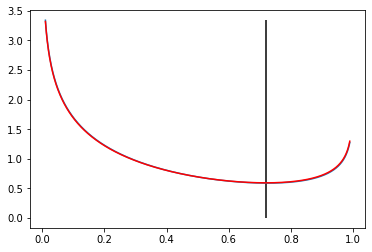

0.7202302302302301


In [ ]:
utility = lambda p: - np.log(p)*p0 - (1-p0)*np.log(1-p)
pp = np.linspace(0.01, .99, 1000)

utility_simulated = utility_sim(pp)
utility_calc = utility(pp)
plt.plot(pp, utility_simulated)
plt.plot(pp, utility_calc, color = "red")
plt.vlines(0.72, 0, np.max(utility_simulated))
plt.show()
print(pp[np.argmin(utility_calc)])


Let's see whay happens with the quadratic error:


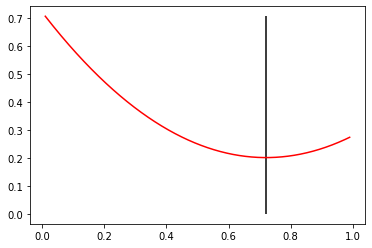

0.7202302302302301

In [ ]:
p0 = 0.72
n = 10000
y = rng.binomial(n = 1, size = n, p = 0.72)
utility = np.vectorize(lambda p: np.mean((y - p)**2))
pp = np.linspace(0.01, .99, 1000)

utility_calc = utility(pp)
plt.plot(pp, utility_calc, color = "red")
plt.vlines(0.72, 0, np.max(utility_calc ))
plt.show()
pp[np.argmin(utility_calc)]


The same! It's in her best interest to report the true $p=p_{0}!$

Now generalize this:

## Definition

> Let $Y$ be a binary random variable with success probability $p_{0}$,
i.e., it takes on the value $1$ with probability $p_{0}$ and $0$
with probability $1-p_{0}$. Let $s(y,p_{0})$ be any function taking
either $y=0$ or $y=1$ as its first argument and $0\leq x\leq1$
as its second. Then $s(y,p_{0})$ is a proper scoring rule if $p_{0}$
minimizes $R(p)=E(s(y,p))$.

In the quadratic case, $s(y,p) = -(y - p)^2$, in the log score case, $s(y,p) = y\log(p) + (1-y)\log(1-p)$. Since both are proper scoring rules, both compell the data to "tell us the truth" in the sense of giving us the true probability
of $Y=1$. Why would be then prefer the log score? Mostly because it has a strong information-theoretical justification, see e.g the wikipedia page on [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). But also since it has a strong
philosophical foundation, see e.g. McCutcheon, R. G. (2019). In Favor of Logarithmic Scoring. Philosophy of Science, 86(2), 286–303. https://doi.org/10.1086/702028. (This paper is not required reading for this course, but I personally enjoyed it quite a bit. And it might be the only time you're asked to read a philosophy paper!)

## The $R^2$ for binary regression


Remember the setup for the $R^{2}$ for non-linear regression:
$$
1-\frac{\sum_{i=1}^{n}(y_{i}-f(x;a_{1},\ldots a_{p}))^{2}}{\sum_{i=1}^{n}(y_{i}-m)^{2}}
$$
In general we could write
$$
R^{2}=1-\frac{R(x)}{R(m)}
$$
Where 
* $R(m)$ measures the distance between our best predictions and the
data $y$, and 
* $R(x)$ measures the distance between our best predictions and the
data $y$ when we take $x$ into account.

The distance function doesn't have to be the quadratic distance function; it could be e.g. the least absolute deviations. But for classification we use the
log score! So, letting $p_i = f(x;a_{1},\ldots a_{p})$, define
$$
l(x) = R(x) = \sum_{i=1}^{n}-y_{i}\log p_{i}-(1-y_{i})\log(1-p_{i}).
$$
This is called the *fitted likelihood*, which measures how well we can predict $y$ using $x$ in terms of the log score. Moreover, define
$$
l(m) = R(m) = \sum_{i=1}^{n}-y_{i}\log m-(1-y_{i})\log(1-m),
$$
which is the *log likelihood of the null model*. It measures how well we can predict $y$ when we don't know any $x$ at all. The reason why we use the terminology *log likelihood* should have been made clear in the last section. 

Now define the pseudo-$R^2$ or McFadden $R^2$ as
$$
R^2_{\textrm{McFadden}} = 1 - \frac{l(x)}{l(m)}.
$$

The likelihood values $l(x)$ and $l(m)$ are calculated virtually any function
doing binary regression. Here's an example:


In [ ]:
probit_fit = smf.probit("admit ~ gre", data = admission).fit()
logit_fit = smf.logit("admit ~ gre", data = admission).fit()

def rsq_mcfadden(fit):
    lower = fit.llnull
    upper = fit.llf
    return 1 - upper / lower

print(rsq_mcfadden(probit_fit), rsq_mcfadden(logit_fit))



Optimization terminated successfully.
         Current function value: 0.607481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607570
         Iterations 5
0.027984163638921422 0.02784206732737804


But we may also access McFadden's $R^2$ directly.

In [ ]:
print(probit_fit.prsquared, logit_fit.prsquared)

The values for McFadden's $R^2$ are small, which is quite typical. Indeed,  McFadden's $R^2$ between $0.2$ and $0.4$ are routinely considered excellent in binary regression, but we would want much larger $R^2$ (usually!) in linear regression. There are two reasons for these small values:

1. The $R^2$ based on the log score is usually smaller than the $R^2$ based on least squares.
2. Both $R^2$s are often small for binary data.

The following picture, Figure 5 from Chapter 5 of [McFadden's Urban Travel Demand: A Behavioral Analysis (1996)
](https://eml.berkeley.edu/~mcfadden/travel.html) illustrates the typical relationsship between the least squares $R^2$ (on the $y$-axis) and the pseudo-$R^2$ on the $x$-axis.

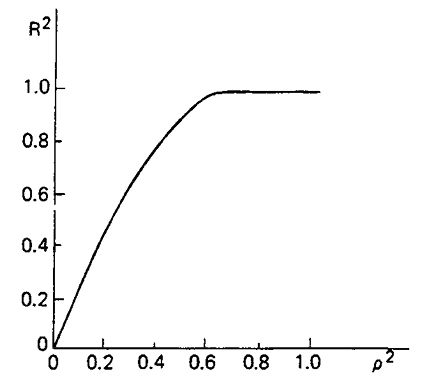

Let's see how an ordinary kind of $R^2$ would work out. To do this, we need to find the parameters of a binary regression fit. We can use the `dir` function for this:

In [ ]:
dir(probit_fit)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_get_endog_name',
 '_get_robustcov_results',
 'aic',
 'bic',
 'bse',
 'conf_int',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'f_test',
 'fittedvalues',
 'get_margeff',
 'initialize',
 'k_constant',
 'llf',
 'llnull',
 'llr',
 'llr_pvalue',
 'load',
 'mle_retvals',
 'mle_settings',
 'model',
 'nobs',
 'normalized_cov_params',
 'params',
 'pred_table',
 'predict',
 'prsquared',
 'pvalues',
 'remove_data',
 'resid_dev',
 'resid_generalized',
 'resid_pearson',
 'resid_response',
 'save',
 'scale',
 'set_null_options',
 'summary',
 'summary2',
 't_test',
 't_

From this list we find the `params` attribute.

In [ ]:
probit_fit.params

Intercept   -1.768186
gre          0.002175
dtype: float64

Using these parameters we find can calculate the least squares variant of the $R^2$ and compare to McFadden's. But we may also use the `predict` method,
which equals the probit function evaluated at all the datapoints with the fitted parameters.

In [ ]:
probit_fit.predict()

array([0.17317206, 0.36967369, 0.48874156, 0.35337789, 0.26199373,
       0.45413437, 0.29108669, 0.1845381 , 0.27635241, 0.40294964,
       0.48874156, 0.20862338, 0.45413437, 0.40294964, 0.40294964,
       0.23446872, 0.47141098, 0.16226213, 0.48874156, 0.27635241,
       0.24802751, 0.36967369, 0.3216052 , 0.38620702, 0.45413437,
       0.48874156, 0.33734655, 0.26199373, 0.47141098, 0.26199373,
       0.27635241, 0.45413437, 0.3216052 , 0.48874156, 0.16226213,
       0.1845381 , 0.30617781, 0.26199373, 0.24802751, 0.26199373,
       0.29108669, 0.30617781, 0.3216052 , 0.24802751, 0.40294964,
       0.22133033, 0.30617781, 0.24802751, 0.20862338, 0.1845381 ,
       0.35337789, 0.20862338, 0.43694412, 0.38620702, 0.36967369,
       0.43694412, 0.29108669, 0.17317206, 0.1845381 , 0.3216052 ,
       0.33734655, 0.29108669, 0.35337789, 0.38620702, 0.30617781,
       0.3216052 , 0.43694412, 0.33734655, 0.30617781, 0.48874156,
       0.35337789, 0.13227522, 0.23446872, 0.30617781, 0.41987

In [ ]:
    y = admission["admit"]
    lower = np.sum((y - np.mean(y)) ** 2)
    upper = np.sum((y - probit_fit.predict()) ** 2)
    1 - upper / lower

0.033664702053135986

This is still really small, but so is the usual $R^2$:

In [ ]:
np.corrcoef(admission["admit"], admission["gre"])[1, 0] ** 2

0.034016002561318794

**Take-away:** McFadden's $R^2$ is typically small, but that's because classification is hard, not because it is "wrong" in any way.

$$E(-Y\log p)=-p_{0}\log p-(1-p_{0})\log(1-p)$$


## Summary


1.   We can do regression with binary responses, but linear regression isn't a good idea, as the line can be less than $0$ and more than $1$.
2.   We will estimate the parameters $a,b$ on the form $F(a + bx)$, where $F$ is
an increasing function from $0$ to $1$. Such functions are called *link functions*.
  * The logistic link yields logistic regression,
  * The probit link, the normal cumulative density function, yields probit regression.
3.  Estimation is almost never done using least squares, but by minimizing the *log score*.
  * This choice may be justified since minimizing the log score is the maximum likelihood estimator, which is asymptotically the best possible estimator when the model is exactly true.
  * It can also be justified since the log score is a proper scoring rule, and it has strong philosophical and information-theoretical justification.
6. Since the log score is a distance, we can construct an $R^2$ for it, called
McFadden's pseudo-$R^2$.


